# PyTorch Implementation with NLP: POS Tagging

#### In this notebook we are gonna implement the PyTorch on the NLP task:POS(Parts of Speech) Tagging . 

## PyTorch tensors
PyTorch defines a class called Tensor (torch.Tensor) to store and operate on homogeneous multidimensional rectangular arrays of numbers. PyTorch Tensors are similar to NumPy Arrays, but can also be operated on a CUDA-capable Nvidia GPU.

Tensors are generalization of vectors and metrices and easily understood as a multidimensional array.In many cases tensors are used as a replacement of Numpy Arrays to use the power of GPU.

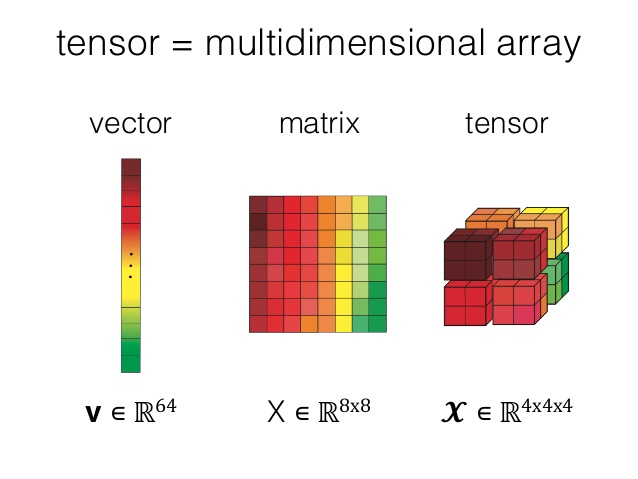

## Modules

#### Autograd module
PyTorch uses a method called automatic differentiation. A recorder records what operations have performed, and then it replays it backward to compute the gradients. This method is especially powerful when building neural networks to save time on one epoch by calculating differentiation of the parameters at the forward pass.It calculates derivatives of the parameters along with the forward propagation and kept record of them and pass them during the backward propagation. This technique helps the model to execute faster.  

#### Optim module
torch.optim is a module that implements various optimization algorithms used for building neural networks. Most of the commonly used methods are already supported, so there is no need to build them from scratch.

#### nn module
PyTorch autograd makes it easy to define computational graphs and take gradients, but raw autograd can be a bit too low-level for defining complex neural networks. This is where the nn module can help.

So let's get started:

## Importing all the necessary Packages

In [6]:
## Importing all the necessary libraries
import pandas as pd   ## loading files
import numpy as np   ##Linear Algebra
import torch       ## Tensors , model building, training and evaluation
import torch.nn as nn   ## Pytorch's Nuearal network class 
import torch.nn.functional as F  ## 
import torch.optim as optim   ## Optimizer

## Downloading/Importing the data

We will be using a already available tagged sentences data , in the NLTK's treebank, for training and validating our model.NLTK is a very popular python natural language processing toolkit, incase you haven't heard of it.

Kindly refer to their [Site](https://www.nltk.org/) for more information.



The foolowing code will import the data for us:



In [3]:
import nltk   ## Data Preprocessing and loading already available data

tagged_sentence = nltk.corpus.treebank.tagged_sents(tagset='universal')
print("Number of Tagged Sentences ",len(tagged_sentence))

Number of Tagged Sentences  3914


As we can see here there are 3914 already tagged sentences present in the data.

In [4]:
# Let's have a look at some sentences

print(tagged_sentence[:3][:10])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

## Creating tagged items dictionaries
Now we will construct a dictionary for all these:

* A word/tag dictionary,
* A letter/character dictionary
* A POS tag dictionary

In [7]:
def word_to_ix(word, ix):     ## ix = index, we are taking indexes of words
    return torch.tensor(ix[word], dtype = torch.long)   ## taking tensors in output

def char_to_ix(char, ix):     
    return torch.tensor(ix[char], dtype= torch.long)   ## taking indexes of character as output in the form of tensors

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)   ## taking indexes of pos tagger into tensor

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)  ## 


word_to_idx = {}   ## word tag dictionary
tag_to_idx = {}    ## POS tag dictionary
char_to_idx = {}    ##  char tag dictionary
for sentence in tagged_sentence:   ## looping through all the sentences  
    for word, pos_tag in sentence:   ## taking words and pos tag as word , tag respectively from each sentence
        if word not in word_to_idx.keys():  
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [8]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 12408
Unique tags: 12
Unique characters: 79


## Splitting the Data into train/test

In [9]:
import random
##taking 95% of tagged sentences randomly
tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))  

train = [tagged_sentence[i] for i in tr_random]  ## taking each sentence from random sentences to train our model

## taking rest 5% of tagged sentences to validate our model 
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random] 

In [18]:
## hyperparameters for our NLP model, feel free to experiment with these
WORD_EMBEDDING_DIM = 1024   
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 2

## The model classes

Here I will construct the model classes, the Word LSTM tagger and the Character LSTM Tagger. The LSTM in both cases takes in a sequence (words or characters), embeds the sequence into an embedding space (dimension of the space is a hyperparameter), and runs the LSTM model.

In our case, first the word level LSTM will take in a sequence of words and convert them into the word embedding space. Similarly, it will take the words sequentially and run the character level LSTM model, which will first take in the sequence of characters in each word and project it in the character embedding space and then run the LSTM model and take its hidden state and feed it back to the word LSTM model.

Using the character level hidden representation for every word as well as the word embedding, the word level model then runs LSTM on the sequence of words, and outputs the predictions for every tag. This prediction is later processed to find the corresponding tags.

Here is the LSTM (Long Short Term Memory) architecture to look at:


file:///home/kavish/Downloads/Tasks_internshala/DevIncept/1_laH0_xXEkFE0lKJu54gkFQ.png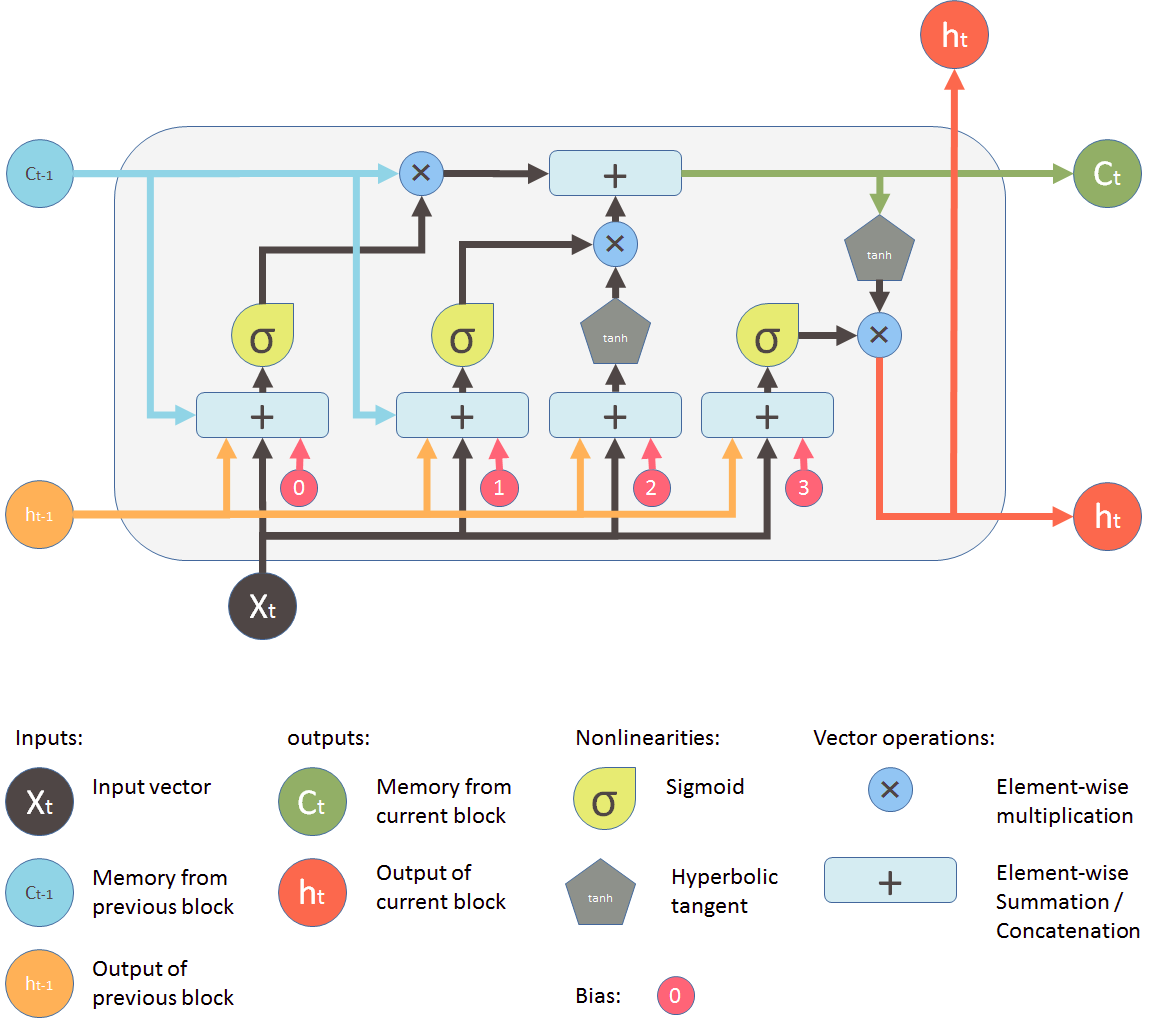

In [14]:
## Constructing a LSTM model class using pytorch's nn module
class DualLSTMTagger(nn.Module):
    ## initializing our model by taking required parameters 
    def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
        super(DualLSTMTagger, self).__init__()
        self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
        
        self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
        self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
        
        self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim)
        self.hidden2tag = nn.Linear(word_hidden_dim, tag_vocab_size)
        
    def forward(self, sentence, words):   ## this function will perform forward propagation
        embeds = self.word_embedding(sentence)
        char_hidden_final = []
        for word in words:
            char_embeds = self.char_embedding(word)
            _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
            word_char_hidden_state = char_hidden.view(-1)
            char_hidden_final.append(word_char_hidden_state)
        char_hidden_final = torch.stack(tuple(char_hidden_final))
        
        combined = torch.cat((embeds, char_hidden_final), 1)

        lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

## Training our model

In [57]:
model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()   ## checking if cuda is available
device = torch.device("cuda:0" if use_cuda else "cpu") ## if cuda available use gpu it otherwise go with cpu

if use_cuda:   ## if cuda available == true
    model.cuda()   ## use cuda to rum our model

# Define the loss function as the Negative Log Likelihood loss (NLLLoss)
loss_function = nn.NLLLoss()  

# We will be using a simple SGD(Stochastic Gradient Descent) optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# The test sentence
seq = "I eat food . She kept waiting for me to show up for 2 hours . But I could not go there .".split()
print("Running a check on the model before training.\nSentences:\n{}".format(" ".join(seq)))

with torch.no_grad():
    
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)  ## giving inouts into the model
    _, indices = torch.max(tag_scores, 1)  
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
    print(ret)
# Training start
print("Training Started")
accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = round(epochs / 1.)
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)
        
        model.zero_grad()  ## removing previously calculated derivates during back propagation
        
        tag_scores = model(sentence, words)  ## getting output predictions from our model
        
        loss = loss_function(tag_scores, targets)  ## calculating loss of our model
        loss.backward()   ##  backward propagation
        optimizer.step()   ## calling optimizer
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))  ## defining the accuracy metric
        if i % interval == 0:   
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:])))

Running a check on the model before training.
Sentences:
I eat food . She kept waiting for me to show up for 2 hours . But I could not go there .
[('I', 'DET'), ('eat', 'NOUN'), ('food', '.'), ('.', 'CONJ'), ('She', '.'), ('kept', 'PRON'), ('waiting', '.'), ('for', 'NUM'), ('me', 'NUM'), ('to', 'NUM'), ('show', 'ADP'), ('up', 'ADP'), ('for', 'DET'), ('2', 'DET'), ('hours', 'X'), ('.', 'ADP'), ('But', 'VERB'), ('I', 'NUM'), ('could', 'PRT'), ('not', '.'), ('go', 'PRT'), ('there', 'PRT'), ('.', '.')]
Training Started


<ipython-input-57-e51e035750a0>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
<ipython-input-57-e51e035750a0>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
<ipython-input-57-e51e035750a0>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in sentence_tag]

Epoch 2 Completed,	Loss 0.00016382303147111088	Accuracy: 0.903212696313858


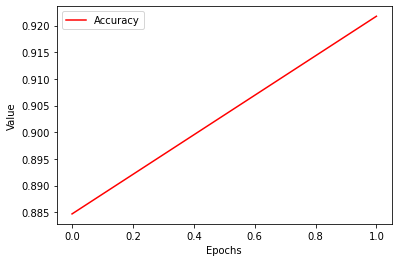

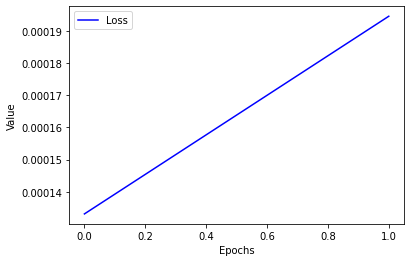

In [58]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list, c="red", label ="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

I have trained this model only for 2 epochs as i do not have gpu in my system.As training for moe epochs slowing down the process and taking much longer time. But i would recommend to train it for at least 10 epochs for better performance.

Let's see how it is making predictions on test sentence.

## Evaluating on test sentence

In [54]:
with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
    print(ret)

<ipython-input-54-a28fb1706407>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
<ipython-input-54-a28fb1706407>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)


[('I', 'PRON'), ('eat', 'VERB'), ('food', 'NOUN'), ('.', '.'), ('She', 'PRON'), ('kept', 'VERB'), ('waiting', 'VERB'), ('for', 'ADP'), ('me', 'PRON'), ('to', 'PRT'), ('show', 'VERB'), ('up', 'ADP'), ('for', 'ADP'), ('2', 'NUM'), ('hours', 'NOUN'), ('.', '.'), ('But', 'CONJ'), ('I', 'PRON'), ('could', 'VERB'), ('not', 'ADV'), ('go', 'VERB'), ('there', 'ADV'), ('.', '.')]


## Result:

It seems our model is able to learn the words well even in the very short training.



## Conclusion:

In this notebook, we have successfully able to build a POS tagger using PyTorch.
It was just a common example of Application of Pytorch. Pytorch can do a lot more complex and advance things as well.As , hereby, our purpose is to get understanding of Pytorch. I hope , this notebook is able to give you a basic understanding of implementation of Pytorch(the how part). In case , if you have any queries, suggestions/feedback or face any problem implementing this, feel free to reach me.If you find anything incomplete or mistaken here, please let me know. 

[Linkedin](https://www.linkedin.com/in/kavish-goyal-595583b2/)  


# Thanks!!